In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh

from db_queries import get_ids, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!uname -a
!pwd
!python --version
!conda info --envs | grep '\*'
!conda list | grep -e pandas -e numpy -e scipy -e statsmodels -e matplotlib -e gbd -e vivarium

Mon Aug 11 00:05:23 PDT 2025
ndbs
Linux long-slurm-sarchive-p0043 5.4.0-215-generic #235-Ubuntu SMP Fri Apr 11 21:55:32 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation
Python 3.11.13
vivarium_csu_alzheimers_artifact  *  /ihme/homes/ndbs/miniconda3/envs/vivarium_csu_alzheimers_artifact
# packages in environment at /ihme/homes/ndbs/miniconda3/envs/vivarium_csu_alzheimers_artifact:
gbd                       4.34.0                   pypi_0    pypi
gbd-mapping               4.1.6                    pypi_0    pypi
ihme-cc-gbd-schema-common 1.13.2                   pypi_0    pypi
matplotlib                3.10.5                   pypi_0    pypi
matplotlib-inline         0.1.7                    pypi_0    pypi
numpy                     1.26.4                   pypi_0    pypi
pandas                    1.5.3                    pypi_0    pypi
pandas-stubs              2.2.3.250308             pypi_0    pypi
scipy               

In [2]:
from vivarium_helpers.vph_output.measures import VPHResults

# File paths


USA:

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model1.0/united_states_of_america/2025_08_04_12_16_36`

China:

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model1.0/china/2025_08_04_13_18_19


In [3]:
results_directory = Path(
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/"
)

model_dir = "model1.0"

usa_dir = "united_states_of_america"
china_dir = "china"

usa_run = results_directory / model_dir / usa_dir / "2025_08_04_12_16_36"
china_run = results_directory / model_dir / china_dir / "2025_08_04_13_18_19"

usa_results = usa_run / "results"
china_results = china_run / "results"

!ls $usa_results

deaths.parquet							 ylds.parquet
person_time_alzheimers_disease_and_other_dementias.parquet	 ylls.parquet
transition_count_alzheimers_disease_and_other_dementias.parquet


# Load and check data

In [4]:
usa = VPHResults.from_directory(usa_results, ext='.parquet')
china = VPHResults.from_directory(china_results, ext='.parquet')

In [5]:
usa.table_names()

['deaths',
 'ylls',
 'transition_count_alzheimers_disease_and_other_dementias',
 'ylds',
 'person_time_alzheimers_disease_and_other_dementias']

In [6]:
usa.deaths

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,early_neonatal,2025,Female,baseline,480,5616,0.0
1,deaths,cause,other_causes,other_causes,early_neonatal,2025,Female,baseline,480,5616,0.0
2,deaths,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,early_neonatal,2025,Male,baseline,480,5616,0.0
3,deaths,cause,other_causes,other_causes,early_neonatal,2025,Male,baseline,480,5616,0.0
4,deaths,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,early_neonatal,2026,Female,baseline,480,5616,0.0
...,...,...,...,...,...,...,...,...,...,...,...
759995,deaths,cause,other_causes,other_causes,95_plus,2099,Male,baseline,258,5616,8.0
759996,deaths,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,95_plus,2100,Female,baseline,258,5616,1.0
759997,deaths,cause,other_causes,other_causes,95_plus,2100,Female,baseline,258,5616,11.0
759998,deaths,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,95_plus,2100,Male,baseline,258,5616,1.0


In [7]:
usa.person_time_alzheimers_disease_and_other_dementias

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,early_neonatal,2025,Female,baseline,480,5616,3.986311
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,early_neonatal,2025,Female,baseline,480,5616,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,early_neonatal,2025,Male,baseline,480,5616,3.488022
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,early_neonatal,2025,Male,baseline,480,5616,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,early_neonatal,2026,Female,baseline,480,5616,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
759995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,95_plus,2099,Male,baseline,258,5616,14.450376
759996,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,95_plus,2100,Female,baseline,258,5616,21.924709
759997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,95_plus,2100,Female,baseline,258,5616,16.941821
759998,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,95_plus,2100,Male,baseline,258,5616,9.965777


# Plot total population over time

In [8]:
usa.person_time_alzheimers_disease_and_other_dementias.input_draw.unique()

array([480, 457, 273, 323, 169, 446, 392, 346, 258, 356])

In [9]:
total_pop = usa.ops.marginalize(
    usa.person_time_alzheimers_disease_and_other_dementias,
    ['sex', 'random_seed', 'sub_entity', 'age_group'],
)
total_pop

,current_year,entity,entity_type,input_draw,measure,scenario,value
0,2025,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,299074.458590
1,2025,alzheimers_disease_and_other_dementias,cause,258,person_time,baseline,299210.989733
2,2025,alzheimers_disease_and_other_dementias,cause,273,person_time,baseline,299104.355921
3,2025,alzheimers_disease_and_other_dementias,cause,323,person_time,baseline,299166.143737
4,2025,alzheimers_disease_and_other_dementias,cause,346,person_time,baseline,299137.741273
...,...,...,...,...,...,...,...
755,2100,alzheimers_disease_and_other_dementias,cause,356,person_time,baseline,170217.960301
756,2100,alzheimers_disease_and_other_dementias,cause,392,person_time,baseline,170352.498289
757,2100,alzheimers_disease_and_other_dementias,cause,446,person_time,baseline,169943.901437
758,2100,alzheimers_disease_and_other_dementias,cause,457,person_time,baseline,170540.353183


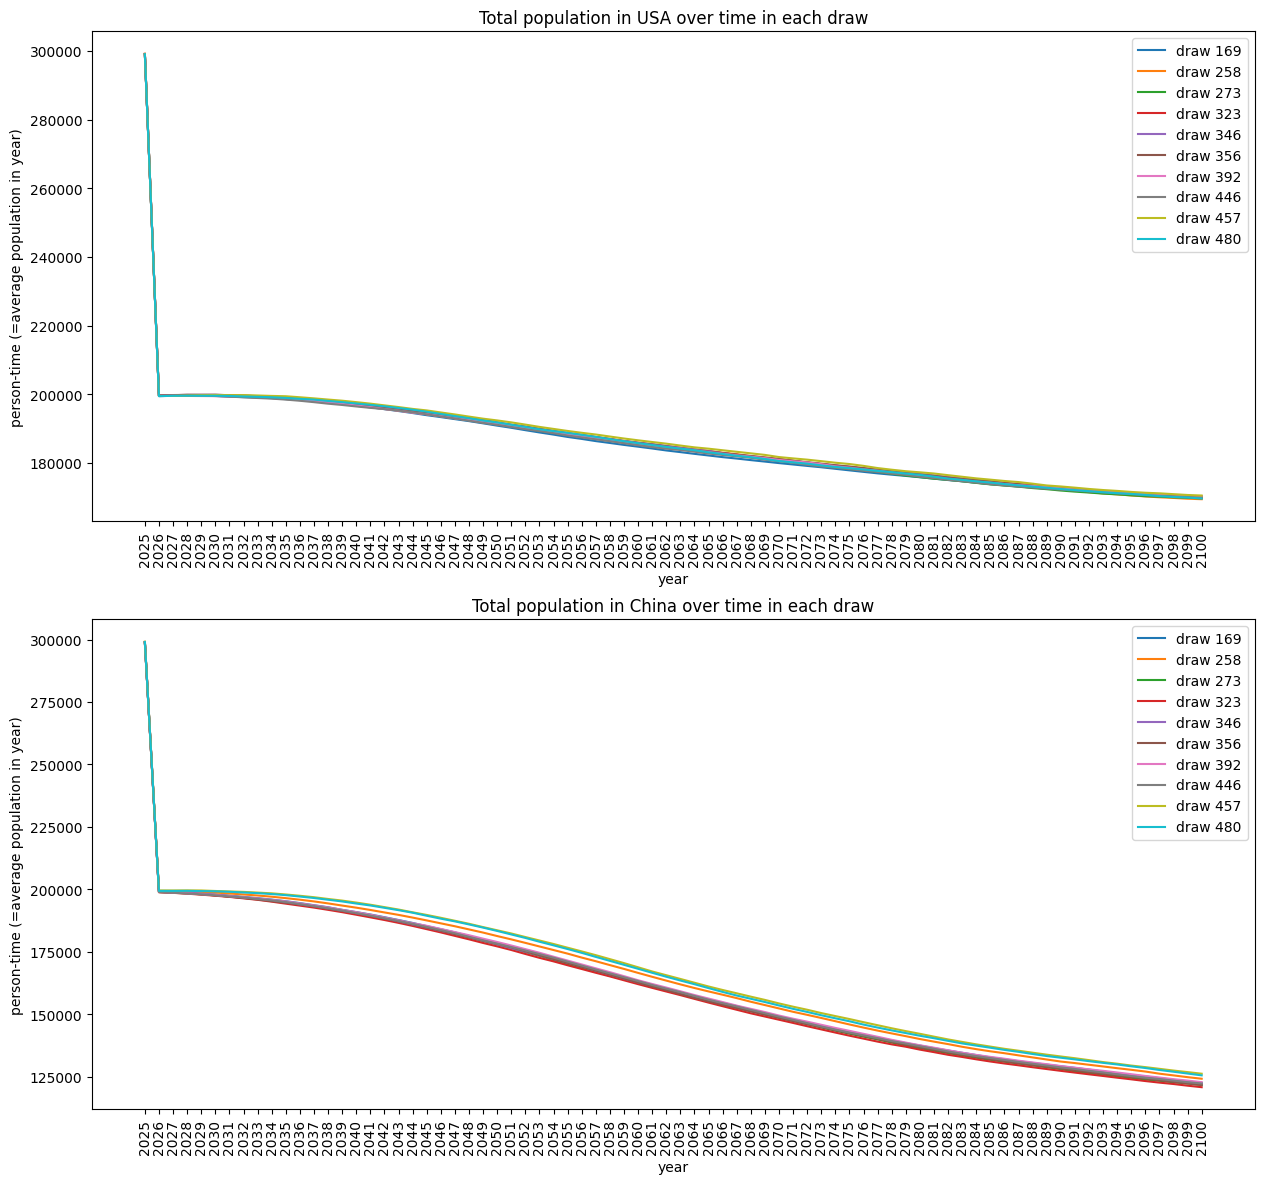

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    total_pop = data.ops.stratify(
        data.person_time_alzheimers_disease_and_other_dementias,
        ['current_year']
    )
    for draw in total_pop.input_draw.unique():
        df_filtered = total_pop.query("input_draw==@draw")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Total population in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("person-time (=average population in year)")
    ax.legend()
plt.show()

# Plot total Alzheimer's population over time

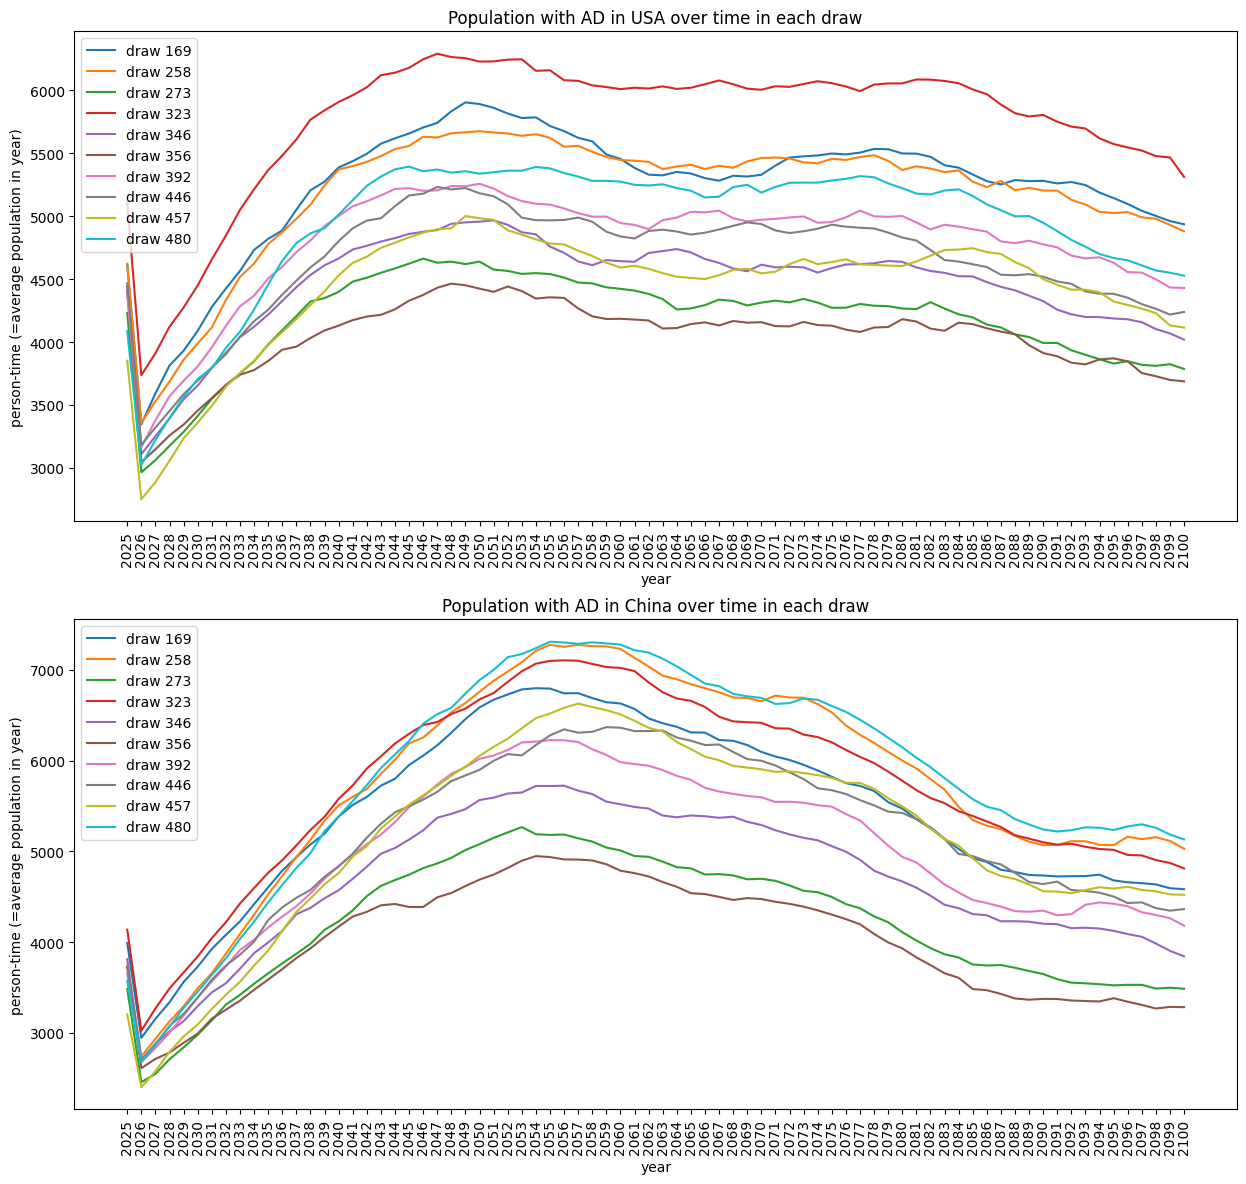

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    alz_pop = data.ops.stratify(
        data.person_time_alzheimers_disease_and_other_dementias,
        ['current_year', 'sub_entity']
    ).query("sub_entity=='alzheimers_disease_and_other_dementias'")
    for draw in alz_pop.input_draw.unique():
        df_filtered = alz_pop.query("input_draw==@draw")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Population with AD in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("person-time (=average population in year)")
    ax.legend()
plt.show()

# Plot overall Alzheimer's prevalence over time

In [12]:
data = usa
prevalence = data.ops.ratio(
    data.person_time_alzheimers_disease_and_other_dementias,
    data.person_time_alzheimers_disease_and_other_dementias,
    strata = 'current_year',
    numerator_broadcast='sub_entity',
)
prevalence

,current_year,input_draw,scenario,sub_entity,value,numerator_measure,denominator_measure,multiplier
0,2025,169,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.984560,person_time,person_time,1
1,2025,169,baseline,alzheimers_disease_and_other_dementias,0.015440,person_time,person_time,1
2,2025,258,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.984552,person_time,person_time,1
3,2025,258,baseline,alzheimers_disease_and_other_dementias,0.015448,person_time,person_time,1
4,2025,273,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.985850,person_time,person_time,1
...,...,...,...,...,...,...,...,...
1515,2100,446,baseline,alzheimers_disease_and_other_dementias,0.024949,person_time,person_time,1
1516,2100,457,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.975866,person_time,person_time,1
1517,2100,457,baseline,alzheimers_disease_and_other_dementias,0.024134,person_time,person_time,1
1518,2100,480,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.973314,person_time,person_time,1


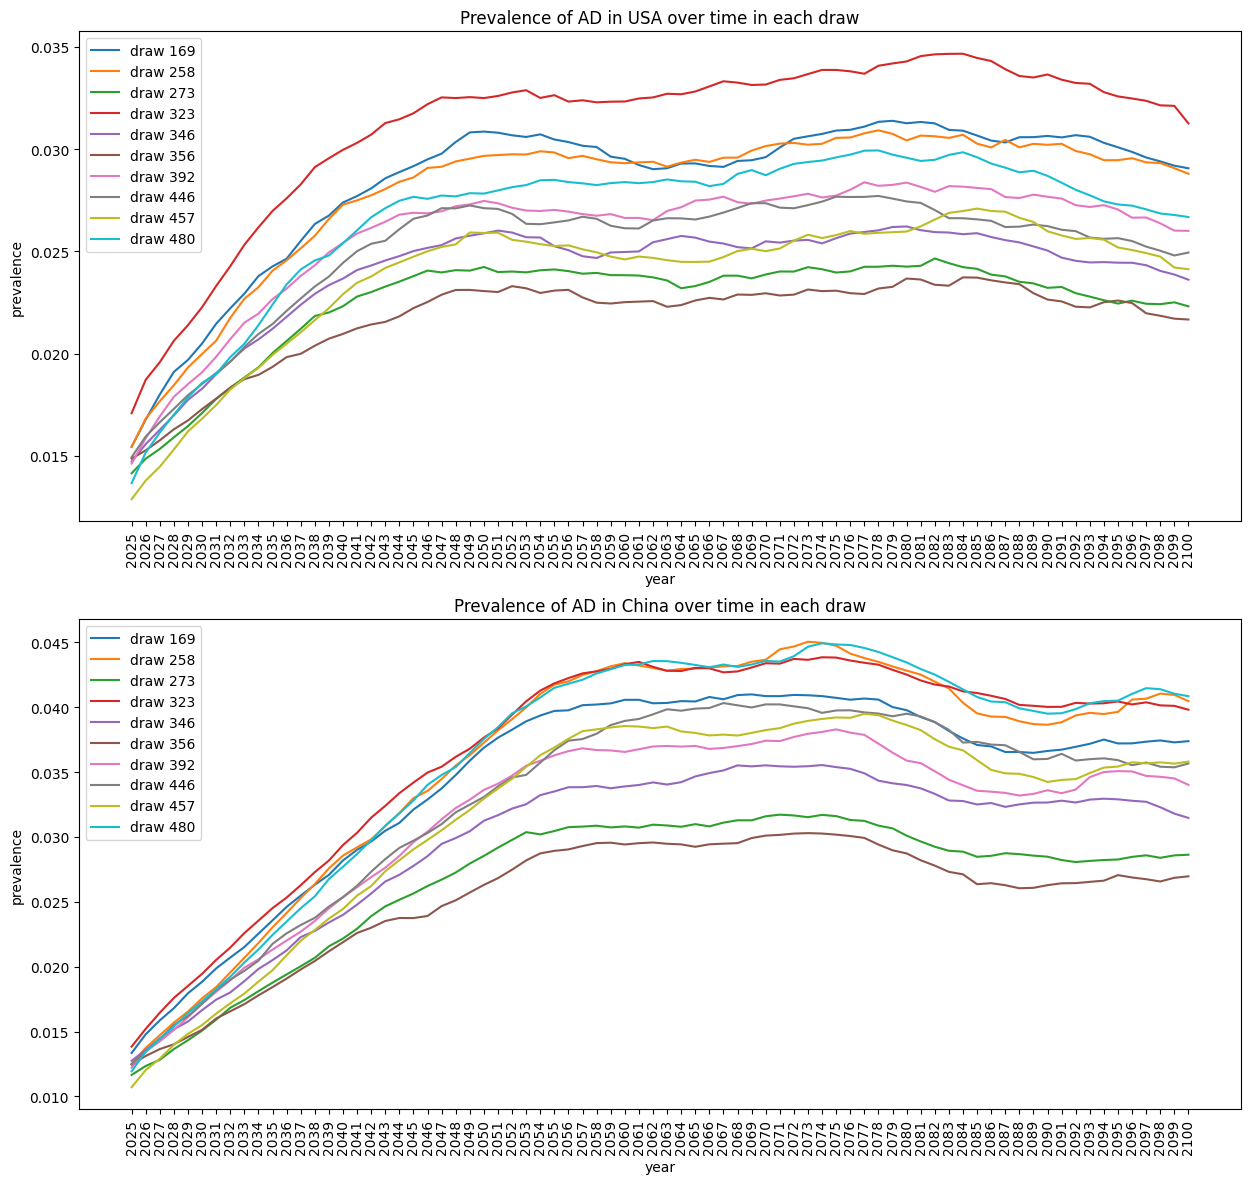

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    prevalence = data.ops.ratio(
        data.person_time_alzheimers_disease_and_other_dementias,
        data.person_time_alzheimers_disease_and_other_dementias,
        strata = 'current_year',
        numerator_broadcast='sub_entity',
    )
    for draw in prevalence.input_draw.unique():
        df_filtered = prevalence.query(
            "input_draw==@draw and sub_entity=='alzheimers_disease_and_other_dementias'")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Prevalence of AD in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("prevalence")
    ax.legend()
plt.show()

# Plot total population of 75-79 year olds over time

In [14]:
usa.person_time_alzheimers_disease_and_other_dementias.age_group.unique()

['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months', '12_to_23_months', ..., '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus']
Length: 25
Categories (25, object): ['1-5_months', '10_to_14', '12_to_23_months', '15_to_19', ..., '90_to_94', '95_plus', 'early_neonatal', 'late_neonatal']

In [15]:
age_group = '75_to_79'

total_pop_75_to_79 = usa.ops.marginalize(
    (
        usa.person_time_alzheimers_disease_and_other_dementias
        .query("age_group == @age_group")
    ),
    ['sex', 'random_seed', 'sub_entity'],
)
total_pop_75_to_79

,age_group,current_year,entity,entity_type,input_draw,measure,scenario,value
0,75_to_79,2025,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,9317.004791
1,75_to_79,2025,alzheimers_disease_and_other_dementias,cause,258,person_time,baseline,9501.869952
2,75_to_79,2025,alzheimers_disease_and_other_dementias,cause,273,person_time,baseline,9246.746064
3,75_to_79,2025,alzheimers_disease_and_other_dementias,cause,323,person_time,baseline,9583.589322
4,75_to_79,2025,alzheimers_disease_and_other_dementias,cause,346,person_time,baseline,9352.881588
...,...,...,...,...,...,...,...,...
755,75_to_79,2100,alzheimers_disease_and_other_dementias,cause,356,person_time,baseline,6518.116359
756,75_to_79,2100,alzheimers_disease_and_other_dementias,cause,392,person_time,baseline,6684.544832
757,75_to_79,2100,alzheimers_disease_and_other_dementias,cause,446,person_time,baseline,6656.142368
758,75_to_79,2100,alzheimers_disease_and_other_dementias,cause,457,person_time,baseline,6829.048597


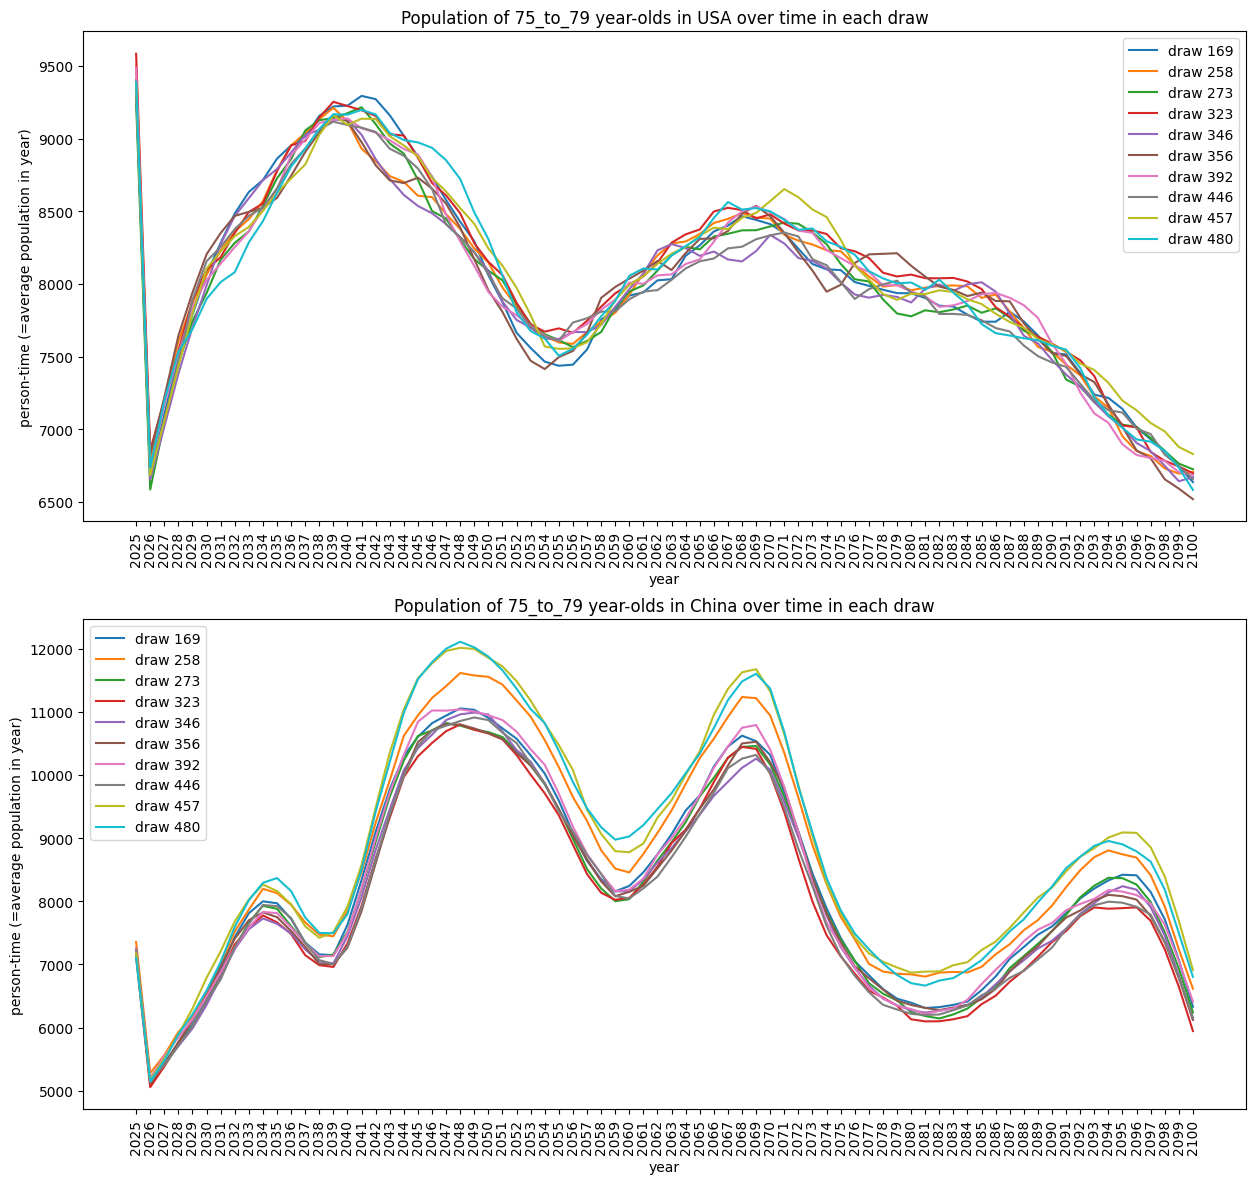

In [16]:
age_group = '75_to_79'

fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    pop = data.ops.stratify(
        data.person_time_alzheimers_disease_and_other_dementias,
        ['current_year', 'age_group']
    )
    for draw in pop.input_draw.unique():
        df_filtered = pop.query("input_draw==@draw and age_group==@age_group")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Population of {age_group} year-olds in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("person-time (=average population in year)")
    ax.legend()
plt.show()

# Plot population of 75-79 year-olds with Alzheimer's over time

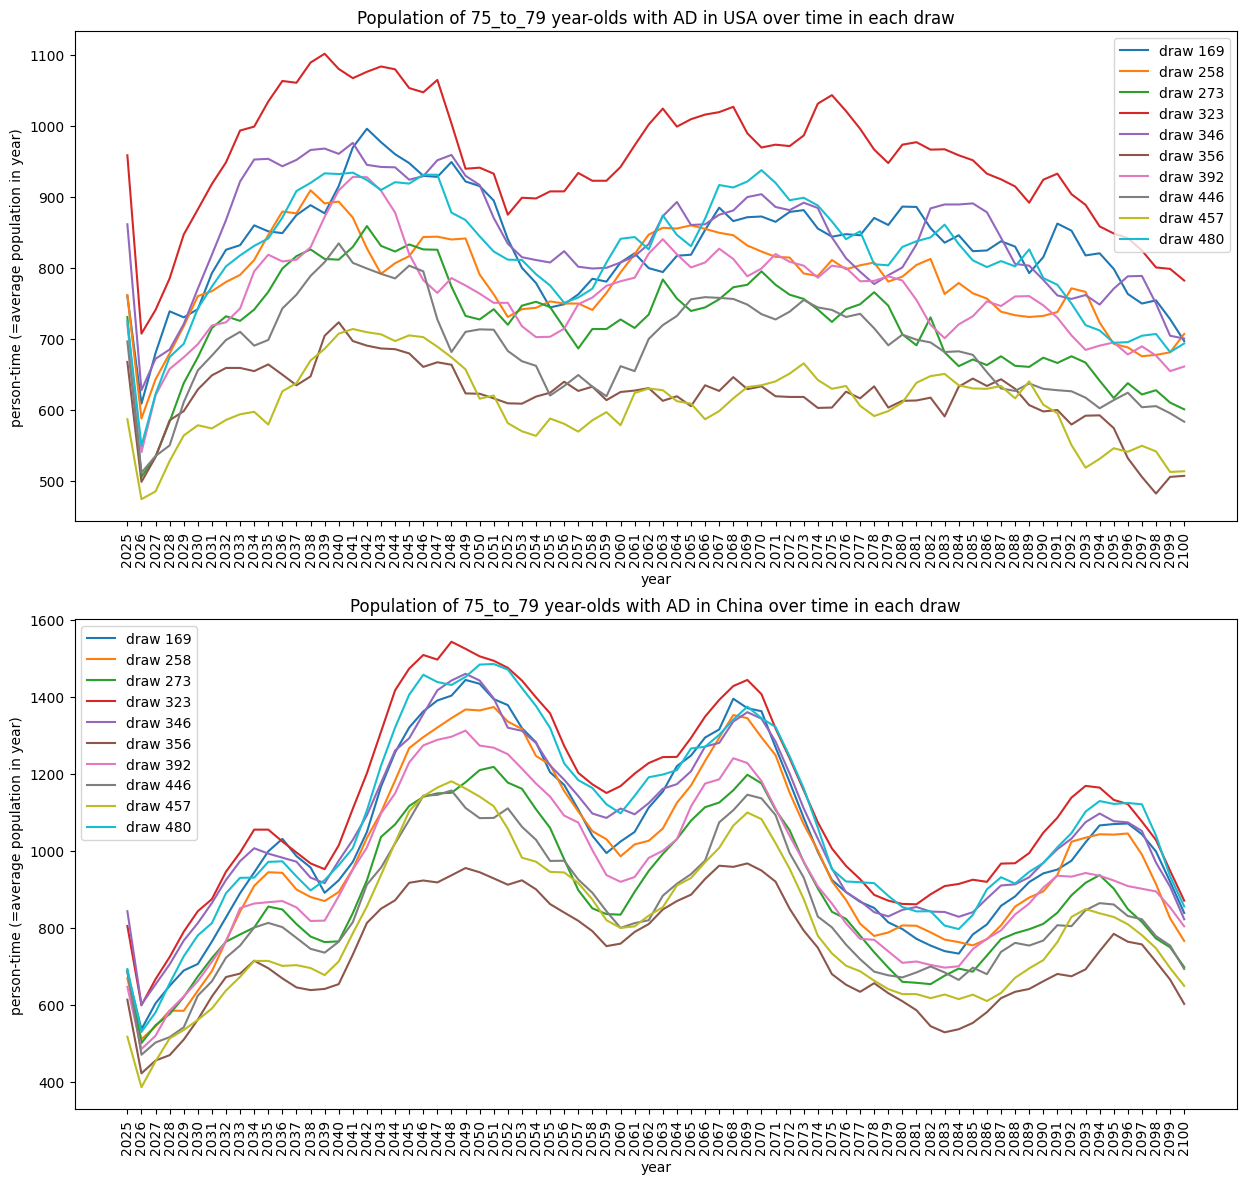

In [17]:
age_group = '75_to_79'

fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    alz_pop = data.ops.stratify(
        data.person_time_alzheimers_disease_and_other_dementias,
        ['current_year', 'sub_entity', 'age_group']
    ).query("sub_entity=='alzheimers_disease_and_other_dementias'")
    for draw in alz_pop.input_draw.unique():
        df_filtered = alz_pop.query("input_draw==@draw and age_group==@age_group")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Population of {age_group} year-olds with AD in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("person-time (=average population in year)")
    ax.legend()
plt.show()

# Plot prevalence of AD in 75-79 year-olds over time

In [18]:
age_group = '75_to_79'
data = usa
# NOTE: I need to add a `prefilter_query` argument to .ratio
# so that I don't have to explicitly filter the numerator and
# denominator
person_time_75_to_79 = (
    data.person_time_alzheimers_disease_and_other_dementias
    .query("age_group==@age_group")
)
prevalence = data.ops.ratio(
    person_time_75_to_79,
    person_time_75_to_79,
    strata = 'current_year',
    numerator_broadcast='sub_entity',
)
prevalence

,current_year,input_draw,scenario,sub_entity,value,numerator_measure,denominator_measure,multiplier
0,2025,169,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.918440,person_time,person_time,1
1,2025,169,baseline,alzheimers_disease_and_other_dementias,0.081560,person_time,person_time,1
2,2025,258,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.919870,person_time,person_time,1
3,2025,258,baseline,alzheimers_disease_and_other_dementias,0.080130,person_time,person_time,1
4,2025,273,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.921000,person_time,person_time,1
...,...,...,...,...,...,...,...,...
1515,2100,446,baseline,alzheimers_disease_and_other_dementias,0.087588,person_time,person_time,1
1516,2100,457,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.924845,person_time,person_time,1
1517,2100,457,baseline,alzheimers_disease_and_other_dementias,0.075155,person_time,person_time,1
1518,2100,480,baseline,susceptible_to_alzheimers_disease_and_other_de...,0.894693,person_time,person_time,1


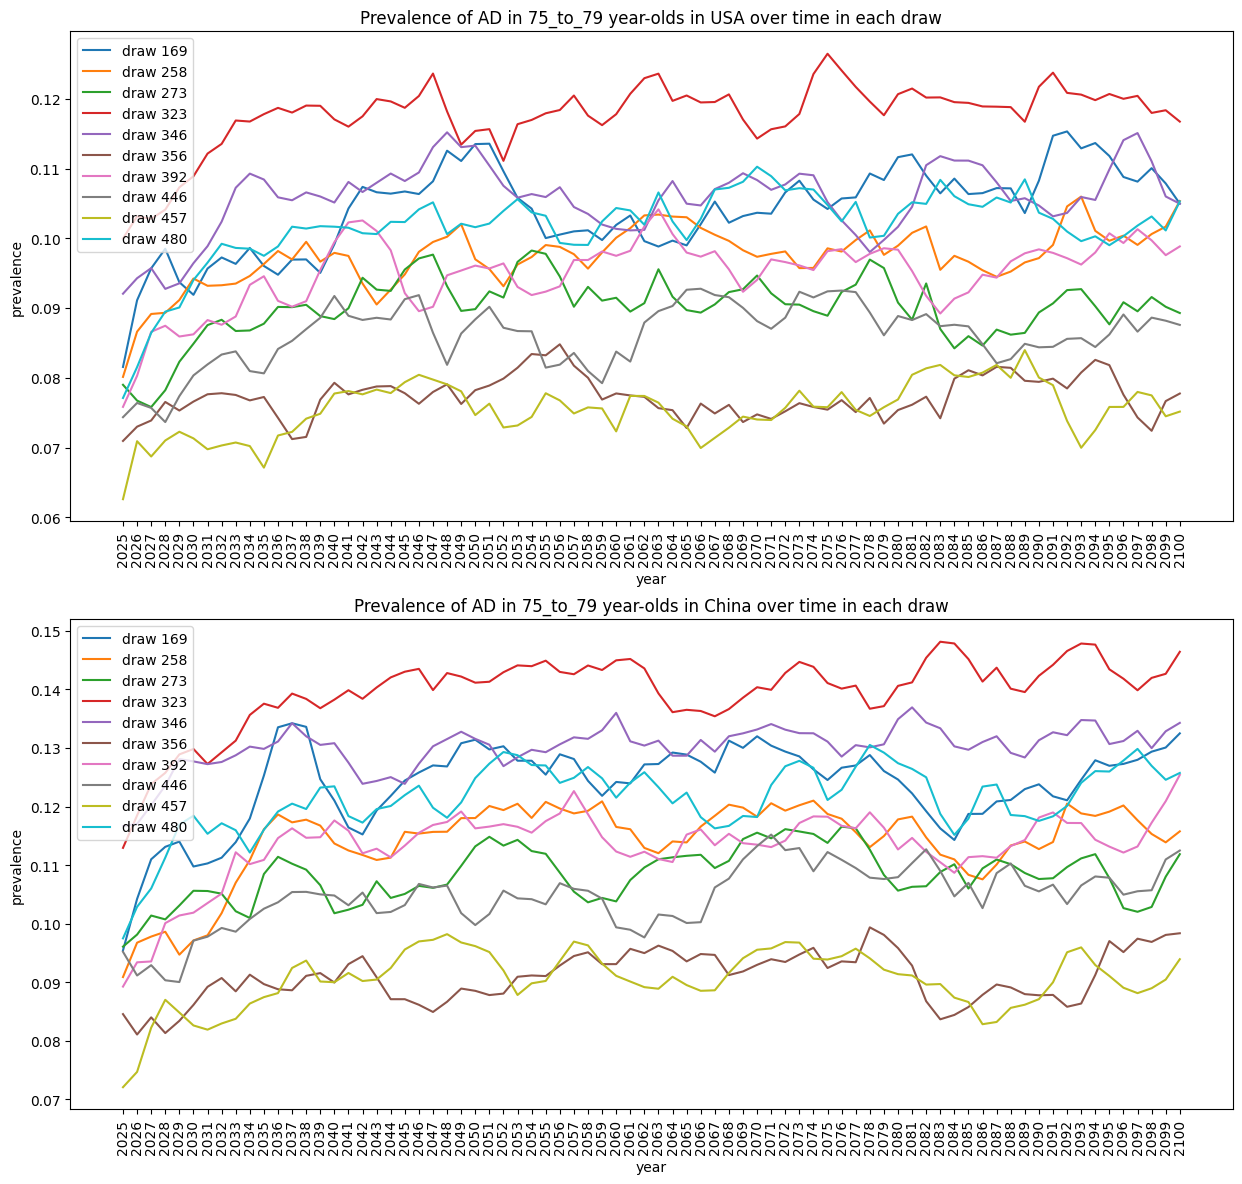

In [19]:
age_group = '75_to_79'

fig, axs = plt.subplots(2, 1, figsize=(15, 14))

for data, country_namme, ax in zip((usa, china), ('USA', 'China'), axs):
    person_time_in_age_group = (
        data.person_time_alzheimers_disease_and_other_dementias
        .query("age_group==@age_group")
    )
    prevalence = data.ops.ratio(
        person_time_in_age_group,
        person_time_in_age_group,
        strata = 'current_year',
        numerator_broadcast='sub_entity',
    )
    for draw in prevalence.input_draw.unique():
        df_filtered = prevalence.query(
            "input_draw==@draw and sub_entity=='alzheimers_disease_and_other_dementias'")
        ax.plot(df_filtered.current_year, df_filtered.value, label=f'draw {draw}')

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"Prevalence of AD in {age_group} year-olds in {country_namme} over time in each draw")
    ax.set_xlabel("year")
    ax.set_ylabel("prevalence")
    ax.legend()
plt.show()